<a href="https://colab.research.google.com/github/mrunalmania/nutriChat/blob/main/nutriChat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create and run rag pipeline.


1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs.)

2. Format the text of the PDF textbook ready for the embedding model.

3. Embed all of the chunks of text in the textbook and turn them into numerical representations (embedding) which we can store forr later.

4. Build a retrieval system that uses a vector search (we can also use FAISS) to find relevant chunks of the text based on the query.

5. Create a prompt that incorporates the retrieved pieces of text.

6. Generate an answet to a query based on the passeges of the textbook with an LLM.


Steps 1-3: Document preprocessing and embedding creation.

Steps 4-6: Search and Answer.


## 1. Document/text processing and embedding creation

Ingredients:
* PDF document of choice (note: this could be almost any kind of document, I've just chosen to focus on PDFs for now.)
* Embedding model of choice



### Import pdf document

In [1]:
!pip install transformers==4.30


In [2]:
import os
import requests

# Get PDF document path
pdf_path  = "human-nutrition-text.pdf"

# Download PDF
if not os.path.exists(pdf_path):
  print(f"[INFO] file doesn't exist, downloading..")

  # enter the url of the pdf.
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local file name to save the downloaded file
  filename = pdf_path

  # Send a GET request to the url
  response = requests.get(url)

  # Check if the request is successfull.
  if response.status_code == 200:
    # Open the file in write mode
    with open(filename, "wb") as f:
      # Write the content of the response to the file
      f.write(response.content)
    print(f"[INFO] The file has been download and saved as {filename}")
  else:
    print(f"[ERROR] Failed to downloah the file, status code: {response.status_code}")
else:
  print(f"[INFO] file already exists, skipping download..")

[INFO] file already exists, skipping download..


We've got the pdf, now let's open it.

In [3]:
!pip install fitz

In [4]:
!pip install PyMuPDF




In [5]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
  """ Performs minor formmating on the text."""

  cleaned_text = text.replace("\n", " ").strip()

  # potentially more text formatting can go here.
  return cleaned_text

# open the pdf document
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []

  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text)
    pages_and_texts.append({"page_number": page_number - 41,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(".")),
                            "page_token_count": len(text)/4,
                            "text": text})
  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path)
print(f"[INFO] {len(pages_and_texts)} pages read.")
pages_and_texts[:2]


0it [00:00, ?it/s]

[INFO] 1208 pages read.


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [6]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 174,
  'page_char_count': 757,
  'page_word_count': 132,
  'page_sentence_count_raw': 5,
  'page_token_count': 189.25,
  'text': 'The  sodium-pota ssium pump  is the  primary  mechanism  for cells to  maintain  water  balance  between  themselves  and their  surrounding  environment .  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 174  |  Electrolytes Important for Fluid Balance'},
 {'page_number': 282,
  'page_char_count': 1247,
  'page_word_count': 266,
  'page_sen

In [7]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,3,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [8]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.594371,198.889901,14.180464,287.148593
std,348.86387,560.441673,95.747365,9.544587,140.110418
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.750000,134.000000,8.000000,190.687500
50%,562.50000,1232.500000,215.000000,13.000000,308.125000
75%,864.25000,1605.250000,271.250000,19.000000,401.312500
max,1166.00000,2308.000000,429.000000,82.000000,577.000000


## Whay would we are about token count

Token count is important to think about because:
1. Embedding model don't deal with infinite tokens.
2. LLMs don't deal with infinte tokens.

For example an embedding model may have been trained to sequences of 384 tokens into numerical space.  

LLM Context window: the number of tokens LLM can take as a input.

# Further text processing (splitting pages into sentences)

Two ways to do this.
1. We've done this by splitting on "." and  " ".
2. We can do this with NLP library such as spacy and NLTK.


In [9]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline,-> turning text into sentences.
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This is another sentence.")

assert len(list(doc.sents)) == 2

# print out our sentences split.
list(doc.sents)

[This is a sentence., This is another sentence.]

In [10]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  # Make sure all sentences are strings. (default type is space dtype)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  # Count the sentences
  item["page_sentence_count_spacy"] = len(item["sentences"])



  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=1)

[{'page_number': 442,
  'page_char_count': 1749,
  'page_word_count': 284,
  'page_sentence_count_raw': 11,
  'page_token_count': 437.25,
  'text': 'Health Consequences of  Alcohol Abuse  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Alcoholic drinks in excess contribute to weight gain by substantially  increasing caloric intake. However, alcohol displays its two-faced  character again in its effects on body weight, making many scientific  studies contradictory. Multiple studies show high intakes of hard  liquor are linked to weight gain, although this may be the result  of the regular consumption of hard liquor with sugary soft drinks,  juices, and other mixers. On the other hand drinking beer and, even  more so, red wine, is not consistently linked to weight gain and  in some studies actually decreases weight gain. The contradictory  results of scientific studies that have examined the association of  alcohol intake with body we

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,14.18,287.15,10.32
std,348.86,560.44,95.75,9.54,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,8.00,190.69,5.00
50%,562.50,1232.50,215.00,13.00,308.12,10.00
75%,864.25,1605.25,271.25,19.00,401.31,15.00
max,1166.00,2308.00,429.00,82.00,577.00,28.00


### Chuking our sentences together

The concept of splitting a larger pieces of text into smaller one is often referred to as text splitting or chunking.

There is no correct way.

We'll keep it simple and split into group of 10 sentences ( however you could yty 5,7,8 )

There are frameworks such as langchain, however we'll stick with pure python.

Why we do this?
1. So our texts are easier to filter (smaller groups of text can be easier to inspecy that large passages of text).
2. So our text chunks can fit into our embedding model context window.
3. So our context passedto an LLM can be more specific and focused.

In [13]:
# Define split size to turn groups of sentences into chunks.
num_sentence_chunk_size = 10

# Creare a function to split the list of texts recursively into chunk size.
# e.g list of 20 -> [10,10], [25] -> [10,10,5]

def split_list(input_list: list[str],
               slice_size: int) -> list[list[str]]:
               return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list, 10)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
# loop through pages and texts and split the sentences into chunks.
for item in tqdm(pages_and_texts):
  item["sentences_chunks"] = split_list(item["sentences"], num_sentence_chunk_size)

  item["num_chunks"] = len(item["sentences_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1091,
  'page_char_count': 1086,
  'page_word_count': 195,
  'page_sentence_count_raw': 9,
  'page_token_count': 271.5,
  'text': 'Image by  Tomasz  Sienick / CC  BY- SA 3.0  Risk Factors for Osteoporosis  A risk factor is defined as a variable that is linked to an increased  probability of developing a disease or adverse outcome. Recall that  advanced age and being female increases the likelihood for  developing osteoporosis. These factors present risks that should  signal doctors and individuals to focus more attention on bone  health, especially when the risk factors exist in combination. This is  because not all risk factors for osteoporosis are out of your control.  Risk factors such as age, gender, and race are biological risk factors,  and are based on genetics that cannot be changed. By contrast,  there are other risk factors that can be modified, such as physical  activity, alcohol intake, and diet. The changeable risk factors for  osteoporosis provide a mecha

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,14.18,287.15,10.32,1.53
std,348.86,560.44,95.75,9.54,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,8.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,13.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,19.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,82.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That will give us more level of granularity.

Meaning we can dive specifically into the text example that was used in our model.

In [17]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentences_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [18]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 859,
  'sentence_chunk': 'should considering their length, and slightly more than 20 percent of children ages two to five are overweight or have obesity.4 Some minority group children, such as Filipinos, Native Hawaiians, and Other Pacific Islanders, in Hawai‘i have higher rates of overweight and obesity. In 2012, 12.8% of Hawai‘i WIC (low- income) participants ages two to four years were overweight and 10.2% had obesity.567 One study that investigated 2000-2010 data for children ages two to eight years in 51 communities in 11 United States Affiliated Pacific (USAP) jurisdictions found that 14.4% of the study population was overweight and 14% had obesity.8 4.\xa0Institute of Medicine. (2011). Early childhood obesity prevention policies. The National Academies Press. 5.\xa0Oshiro C., Novotny R., Grove J., Hurwitz E. (2015). Race/ ethnic differences in birth size, infant growth, and body mass index at age five years in children in Hawaii. Childhood\xa0Obesity,\xa011(6),6

In [19]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filter chunks of text for short chunks.

These chunks may not contain much useful information.

In [20]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(n=5).iterrows():
    print(f"chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

chunk token count: 9.25 | Text: PART XIX APPENDICES Appendices | 1149
chunk token count: 8.0 | Text: For example, 856 | Toddler Years
chunk token count: 25.75 | Text: http:/ /www.ajcn.org/cgi/ pmidlookup?view=long&pmid=10197575. Accessed October 6, 2017. 640 | Magnesium
chunk token count: 21.75 | Text: http:/ /www.health.gov.fj/?page_id=1406. Accessed November 12, 2017. 652 | Introduction
chunk token count: 28.0 | Text: https:/ /jamanetwork.com/journals/jama/ fullarticle/195531. Accessed October 5, 2017. 538 | Fat-Soluble Vitamins


In [21]:
# Filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_length[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [22]:
random.sample(pages_and_chunks_over_min_token_length, k=1)

[{'page_number': 631,
  'sentence_chunk': 'Phosphorus UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Phosphorus’s Functional Role Phosphorus is present in our bodies as part of a chemical group called a phosphate group. These phosphate groups are essential as a structural component of cell membranes (as phospholipids), DNA and RNA, energy production (ATP), and regulation of acid- base homeostasis. Phosphorus however is mostly associated with calcium as a part of the mineral structure of bones and teeth.\xa0Blood phosphorus levels are not controlled as strictly as calcium so the PTH stimulates renal excretion of phosphate so that it does not accumulate to toxic levels. Dietary Reference Intakes for Phosphorus In comparison to calcium, most Americans are not at risk for having a phosphate deficiency. Phosphate is present in many foods popular in the American diet including meat, fish, dairy products, processed foods, and beverages. Pho

### Embedding our chunks.

Embedding are broad but powerfull concept.

While humans understance text, machines understands numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifially embeddings.

A useful numerical representations.

The best part about embeddings is that they are a **learned representation**.


In [23]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.0
    Uninstalling transformers-4.30.0:
      Successfully uninstalled transformers-4.30.0


In [24]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-mpnet-base-v2",
                                      device="cpu")


# create a list of sentences
sentences = ["This framework generates embeddings for each input sentence",
             "Sentences are passed as a list of string.",
             "The quick brown fox jumps over the lazy dog."]

# sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# see the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print()




Sentence: This framework generates embeddings for each input sentence
Embedding: [ 6.41692942e-03  7.04136817e-03 -2.81441920e-02  5.12471721e-02
 -8.93960800e-03  2.12669224e-02  2.30778418e-02 -1.44859785e-02
 -5.55310957e-03 -2.49297973e-02  4.53492738e-02  2.48959735e-02
 -3.07579394e-02  5.66225052e-02  6.32021800e-02 -5.62528111e-02
  5.16509749e-02  5.78279700e-03 -2.62116604e-02  1.31878909e-03
  1.99272353e-02 -1.30592426e-03 -2.28708494e-03  4.72541489e-02
 -3.72495241e-02 -2.85245627e-02 -4.10240702e-02 -1.57975890e-02
  3.17328097e-03 -8.74196528e-04 -2.96459366e-02  3.21501456e-02
  3.51344422e-02  1.09738167e-02  9.16707108e-07 -1.18588237e-03
 -2.53640655e-02 -7.92881101e-03 -5.09479223e-03  7.40658911e-03
  2.80067995e-02  1.06996251e-02  1.07513322e-02  2.76827794e-02
 -5.19132763e-02 -4.98179197e-02  5.34074046e-02  5.79067916e-02
  7.86073804e-02  7.73014799e-02 -1.01112127e-02 -6.35445789e-02
 -1.71579309e-02 -6.77370466e-03 -2.45818519e-03  2.61346102e-02
 -5.38513

In [25]:
embeddings[0].shape

(768,)

In [26]:
embedding = embedding_model.encode("My favourite food is pizza")
embedding

array([-2.84782611e-02,  8.78609866e-02, -8.21410771e-03, -5.05623594e-03,
        4.30009700e-02,  2.07338072e-02, -9.52677727e-02,  2.43034232e-02,
        1.71684604e-02,  2.73140911e-02, -3.12348120e-02,  1.25562018e-02,
        3.16011757e-02,  3.81483212e-02, -4.36463133e-02, -9.59198922e-03,
        1.14328098e-02,  1.23878894e-02,  3.49788517e-02,  4.24929485e-02,
       -2.18235906e-02,  2.38218475e-02, -1.19717484e-02, -1.30439056e-02,
       -4.68739122e-02,  5.67231851e-04,  9.20867920e-03, -3.10846586e-02,
       -2.01043691e-02,  3.54395956e-02, -1.60735473e-02, -2.74877250e-02,
       -4.18803506e-02, -4.08927836e-02,  1.41711166e-06,  2.26261169e-02,
       -5.45817241e-03,  1.68682430e-02,  7.33489729e-03,  2.16904785e-02,
       -3.54458615e-02, -1.03681581e-02, -2.13422347e-02,  7.11440051e-04,
       -2.27425229e-02, -9.92522575e-03,  5.60659543e-03,  7.19825774e-02,
       -2.81078238e-02,  3.88087481e-02,  1.64877083e-02, -1.00711145e-01,
       -6.03856780e-02, -

In [27]:
%%time
embedding_model.to("cuda")

# embed each chunk 1 by 1
for item in tqdm(pages_and_chunks_over_min_token_length):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 1min 48s, sys: 489 ms, total: 1min 48s
Wall time: 31.7 s


In [28]:
%%time

text_chunks = [item["sentence_chunk"] for tem in pages_and_chunks_over_min_token_length]
text_chunks[419]

CPU times: user 130 µs, sys: 4 µs, total: 134 µs
Wall time: 136 µs


'23. Vitamin D reused “The Functions of Vitamin D” by Allison Calabrese / Attribution – Sharealike 24. Vitamin K reused “Kale Lacinato Lacinato Kale” by BlackRiv\xa0/ Pixabay License; “Phylloquinone structure” by Mysid\xa0/ Public Domain 1166 | Attributions'

In [29]:
len(text_chunks)

1680

In [30]:
%%time
# Embed all texts in batches
text_chunks_embeddings = embedding_model.encode(text_chunks, batch_size=32, show_progress_bar=True, convert_to_tensor=True)

text_chunks_embeddings

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

CPU times: user 10.5 s, sys: 106 ms, total: 10.6 s
Wall time: 7.54 s


tensor([[ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299],
        ...,
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file


In [31]:
text_chunks_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_length)
embeddings_df_save_path = "text_chunks_embeddings_df.csv"
text_chunks_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [32]:
# Import saved file and view.
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


If your embedding databse is really large (e.g 100k - 1m samples) you might want to look into using a vector database for storage

## 2. RAG Search and answer

retrieve relevant passages based on a query and use those passages  to augment an input to an LLM so it can generate an output on those relevant passages.

### Similarity search

Embeddings can be used for almost any type of data.

For example, you can turn sounds, images and texts into embeddings.

Comparing embeddings is known as similarity search, vector search, or semantic search.

In our case we want to query our textbook based on semantics or "vibe"

So if I want for "macrontrient nutrition" I should get relevant passages to that text but may not contain exactly the words "macronutrients".


Where as with keyword search, if I search "apple" I get back passages with "specifically apple".



In [33]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [34]:

text_chunks_and_embedding_df["embedding"]

0       [0.0674242675, 0.0902281404, -0.00509548886, -...
1       [0.0552156419, 0.0592139773, -0.0166167244, -0...
2       [0.0279801842, 0.0339813754, -0.020642668, 0.0...
3       [0.0682566911, 0.0381275006, -0.00846854132, -...
4       [0.0330264494, -0.0084976349, 0.00957159605, -...
                              ...                        
1675    [0.0185622536, -0.0164277665, -0.0127045633, -...
1676    [0.0334720612, -0.0570440851, 0.0151489386, -0...
1677    [0.0770515501, 0.00978557579, -0.0121817412, 0...
1678    [0.103045158, -0.0164701864, 0.00826846063, 0....
1679    [0.086377345, -0.0125358943, -0.011274674, 0.0...
Name: embedding, Length: 1680, dtype: object

In [35]:
embeddings.shape

torch.Size([1680, 768])

In [36]:
embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [37]:
# Create model
from sentence_transformers import SentenceTransformer, util

embedding_model = SentenceTransformer("all-mpnet-base-v2", device=device)



Embedding mode ready!

Let's create a small semantic search pipeline.

In essence, we want to search for a query (e.g. "macronutrient funcions") and get back relevant passages from our textbook.

We can do so with the following steps.

1. Define a query string
2. Turn query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embeddings.
4. Sort the result from the 3 in descendind order

Note: to use dot product, ensure vector sizes are of same shape (e.g (768,)) and tensors/vectors are in same datatype (e.g. torch.float32)

In [38]:
# 1. Define the query
query = "good food for protein"
print(f"Query: {query}")

# 2. Turn the query into an embedding
# Note: it's important to embed your query with same model you embedding your passages.
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3. Get similarity scores with the dot product (use cosine similarity if output aren't normalized)
from time import perf_counter as timer
start_time = timer()

dot_scores = util.dot_score(query_embedding, embeddings)[0]
end_time = timer()

print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")

# 4. Sort the result from the 3 in descending order
top_result_dot_product = torch.topk(dot_scores, k=5)

top_result_dot_product


Query: good food for protein
Time taken to get scores on 1680 embeddings: 0.00375 seconds


torch.return_types.topk(
values=tensor([0.7691, 0.7649, 0.6903, 0.6845, 0.6834], device='cuda:0'),
indices=tensor([611, 616, 620, 615, 602], device='cuda:0'))

In [39]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Shape of larger embeddings: {larger_embeddings.shape}")

Shape of larger embeddings: torch.Size([168000, 768])


In [40]:
# perform dot product across 168000 embeddings.

from time import perf_counter as timer
start_time = timer()

dot_scores = util.dot_score(query_embedding, larger_embeddings)[0]
end_time = timer()

print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds")


Time taken to get scores on 1680 embeddings: 0.00074 seconds


we can see that searching over embedding is very fast.

But if you had 10M+ embeddings, you likely to create an index.

Index is like letters in dictionary.

for example, if you want to search "duck" in the dictionry, you'd start with d, du, duc,...

Currently we are doing exhaustive search, we compare our query emvedding with all other embedding.

An index helps to narrow it down.

A popular indexing library for vector search is FAISS.

Also we use Approximate Nearest Neighbour search (ANNs) one of the  techniques that FAISS library provide.



Let's make our vector search result pretty

In [41]:
import textwrap
def print_wrapped(text, wrpa_lenghth=80):
  wrapped_text = textwrap.fill(text, wrpa_lenghth)
  print(wrapped_text)
  return wrapped_text

In [42]:
query = "good food for protein"
print(f"Query: '{query}' \n")
print("Results:")

# loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_result_dot_product[0],top_result_dot_product[1]):
  print(f"Score: {score:.4f}")
  print(f"Text:")
  print(pages_and_chunks[idx]["sentence_chunk"])
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'good food for protein' 

Results:
Score: 0.7691
Text:
Dietary Sources of Protein The protein food group consists of foods made from meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the Harvard School of Public Health, “animal protein and vegetable protein probably have the same effects on health. It’s the protein package that’s likely to make a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins, Diet, and Personal Choices | 411
Page number: 411


Score: 0.7649
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week (typically as two 4-ounce servings) to assure they are getting the healthy omega-3 fatty acids that have been linked to a lower risk for heart disease. Another tip is choosing to eat dry beans, peas, or soy products as a main dish. Some of the menu choices include chili with kidney and pinto beans, hummus on pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of w

Note: We could potentially improve the orders of these results with a reranking model. A model that has been trained specifically to take search results (e.g. the top 25 semntic results) and rank them in order from the most likely top-1 to least.

To check our result, what if we wanted to automatically surface the page of text related to our query?

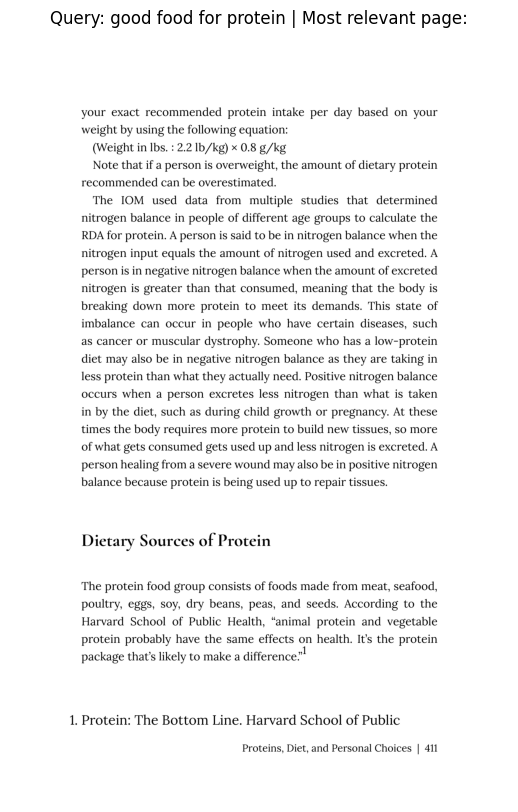

In [43]:
import fitz

# open the PDF
pdf_path = "human-nutrition-text.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(411+41) # page numbers of our pdf starts 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# save imag
img.save("ouput_file_name.png")
doc.close()

# convert pix map to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape(img.h, img.w, img.n)

import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.axis('off')
plt.title(f"Query: {query} | Most relevant page:")
plt.show()

### similarity measures: dot product and cosine similarity

Two of the most common similarity measures, between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have directions and magnitude.


In [44]:
import torch

def dot_product(vector1, vector2):
  return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
  dot_product= torch.dot(vector1, vector2)

  # Get the euclidean/L2 norm
  norm_vector1 = torch.sqrt(torch.sum(vector1**2))
  norm_vector2 = torch.sqrt(torch.sum(vector2**2))

  return dot_product / (norm_vector1 * norm_vector2)

# example vectors/tensors
vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2, -3], dtype=torch.float32)

# Calculate dot product
print(f"Dot product between vector 1 and vector 2: {dot_product(vector1, vector2):.4f}")
print(f"Dot product between vector 1 and vector 3: {dot_product(vector1, vector3):.4f}")
print(f"Dot product between vector 1 and vector 4: {dot_product(vector1, vector4):.4f}")

# Cosine similarity
print(f"Cosine similarity between vector 1 and vector 2: {cosine_similarity(vector1, vector2):.4f}")
print(f"Cosine similarity between vector 1 and vector 3: {cosine_similarity(vector1, vector3):.4f}")
print(f"Cosine similarity between vector 1 and vector 4: {cosine_similarity(vector1, vector4):.4f}")

Dot product between vector 1 and vector 2: 14.0000
Dot product between vector 1 and vector 3: 32.0000
Dot product between vector 1 and vector 4: -14.0000
Cosine similarity between vector 1 and vector 2: 1.0000
Cosine similarity between vector 1 and vector 3: 0.9746
Cosine similarity between vector 1 and vector 4: -1.0000


### functionizing our semantic search pipeline.

Let's put all of the steps above for semantic search in a function or 2 to repeat it.

In [45]:
def retrieval_relevant_resources(query: str,
                                 embeddings: torch.tensor,
                                 model: SentenceTransformer = embedding_model,
                                 n_resources_to_return: int = 5,
                                 print_time: bool = True):
  """
  Embeds the queary with model and return the top k scores and indices from the embeddings.

  """

  # Embed the query
  query_embedding = model.encode(query, convert_to_tensor=True)

  # Get dot product scores
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time= timer()
  if print_time:
    print(f"[INFO] Dot product time: {end_time - start_time:.4f} seconds")

  scores, indices = torch.topk(dot_scores, k=n_resources_to_return)

  return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int = 5):
  """
  FInds relevant passages given a query and prints them out alog with scores.
  """

  scores, indices = retrieval_relevant_resources(query, embeddings, n_resources_to_return=n_resources_to_return)
  for score, idx in zip(scores, indices):
    print(f"Score: {score:.4f}")
    print(f"Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"], )
    print(f"Page Number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

In [46]:
query = "food high in fiber"

print_top_results_and_scores(query, embeddings)

[INFO] Dot product time: 0.0001 seconds
Score: 0.7015
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page Number: 276


Score: 0.6864
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than insoluble fibers, but even s

### Getting an LLM for local generation

We want to focus on local generation.

However, this process will also works well with LLM API.



In [47]:
!nvidia-smi

Wed Apr 24 00:57:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |   1557MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Since our memory is less than 15 GB, we should use Gemma 2b it model.

### Loading LLM

We can load llm locally using hugging face transformers.


In [48]:
!pip install transformers

To get a model running locally, we need a few things.

1. A qunatization config (optional) - it is a config on what precision to load the model in.
2. A model ID - this will tell hugging face transformer which model/tokenizer to load.
3. A tokenizer - this turns text into numbers ready for the LLM. (it's different from the embedding model.)
  .  a tokenizer is specfic to our model.
4. An LLM model - this will be what we use to generate text based on input!.

> **Note** There are many tips and tricks to loading and making LLM work faster. One of the best ones is flash_attn (Flash Attention 2).

In [49]:
import transformers
transformers.utils.is_flash_attn_2_available()

False

In [50]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = "google/gemma-2b-it" # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [51]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
    

In [53]:
def get_num_params(model):
  """
  Returns the number of parameters in the model.
  """
  return sum(p.numel() for p in model.parameters())

get_num_params(llm_model)

1515268096

In [56]:
def get_model_mem_size(model):
  # get model params and buffer size
  mem_params = sum([p.nelement() * p.element_size() for p in model.parameters()])
  mem_buffer = sum([b.nelement() * b.element_size() for b in model.buffers()])

  # get model size
  mem_model = mem_params + mem_buffer

  # convert to GB
  mem_model  = mem_model / 1e9
  return f"{mem_model:.2f} GB"

get_model_mem_size(llm_model)

'2.04 GB'

We got the size of our model.

This means to load Gemma-2b-it in float16 we need 2.04 GB of VRAM

### Generate text with our LLM.

Let's generate text with local LLM.

* Note:
Some models have beed trained/tuned to generate text with specific template in mind.

Because Gemma-2b-it has been trained in instruction-tuned manner, we should follow instruction based.

In [62]:
input_text = "How long should infants be breastfed for ?"

print(f"Input text: \n {input_text}")

# Create the prompt template for instruction tuned model.
dilogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dilogue_template, tokenize = False, add_generation_prmopt = True)

print(f"\n Prompt (Formatted): \n{prompt}")


Input text: 
 How long should infants be breastfed for ?

 Prompt (Formatted): 
<bos><start_of_turn>user
How long should infants be breastfed for ?<end_of_turn>



In [63]:
%%time
# Tokenize the input text (turn it into numbers and send it to the GPU)
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate outputs from local llm
outputs = llm_model.generate(**input_ids, max_new_tokens=256)

print(f"\n Model output (tokens): \n{outputs}")



 Model output (tokens): 
tensor([[     2,      2,    106,   1645,    108,   2299,   1497,   1412,  45770,
            614,  14665,  30629,    604,   1654,    107,    108,    109,  12362,
            577,    573,   3725,  13322,    576, 125142, 235269,  45770,   1412,
            614,  14665,  30629,    604, 235248, 235318,   4063, 235269,    675,
            793,   6792,   2960,    689,  10513,   3274, 235248, 235274,   1162,
            576,   3911, 235265,      1]], device='cuda:0')
CPU times: user 1.42 s, sys: 1.96 ms, total: 1.42 s
Wall time: 1.44 s


In [64]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"\n Model output (text): \n{outputs_decoded}")


 Model output (text): 
user
How long should infants be breastfed for ?


According to the American Academy of Pediatrics, infants should be breastfed for 6 months, with no solid food or formula until 1 year of age.


In [65]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [66]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results.

scores, indices = retrieval_relevant_resources(query=query,
                                               embeddings = embeddings
                                               )
score, indices

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Dot product time: 0.0001 seconds


(tensor(0.6834, device='cuda:0'),
 tensor([ 700,  722, 1510, 1517,  710], device='cuda:0'))

# augmenting our prompt with context items.

we've done retrieval.

We've done generation.

Time to augment.


Prompt engineering is an active feild of reserch and many new styles of technique comes up

We are going to use couple of prompt engineering technique.
1. Give clear instruction.
2. Give few examples of input/output (e.g. gven this input, I'd like this output).

3. Give room to think (e.g. create a scratch pad/"show your working"/ "let's think step by step")

Let's create a function to format the prompt with context items.

In [105]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
  context = "-" + "\n -".join([item["sentence_chunk"] for item in context_items])

  base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}

User query: {query}
Answer:"""
  base_prompt = base_prompt.format(context=context, query=query)

  # Create the prompt template for instruction-tuned model.

  dialogue_template = [
      {"role": "user",
       "content": base_prompt}
  ]

  # Apply the chat template
  prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
  return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieval_relevant_resources(query=query,
                                               embeddings = embeddings
                                               )
# Create a list of context items.
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query, context_items=context_items)

print(f"\n Prompt (Formatted): \n{prompt}")


Query: How often should infants be breastfed?
[INFO] Dot product time: 0.0001 seconds

 Prompt (Formatted): 
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone 

In [97]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generae an output tokens
outputs = llm_model.generate(**input_ids,  temperature=0.7, do_sample=True, max_new_tokens=256 )

# temprature -> lower the value, the more determinstic text, the higher the value the more creative text.

# Turn the output tokens into text
outputs_decoded = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"\n Model output (text): \n{outputs_decoded.replace(prompt, '')}")

Query: Describe the process of digestion and absorption of nutrients in the human body.

 Model output (text): 
<bos>Sure, here's a summary of the relevant passages:

**Digestion:**

* The digestive system begins with the sense of hunger, which triggers a message to the brain about the need to eat.
* The digestive system consists of several organs, including the mouth, pharynx, esophagus, stomach, small intestine, large intestine (colon), rectum, and anus.
* The digestive system breaks down the components of food into smaller components that can be absorbed and processed by cells for energy or used as building blocks for new cells.

**Absorption:**

* Nutrients from the food are first absorbed into the bloodstream either directly or repackaged in the body.
* Water-soluble nutrients travel first to the liver, where they are controlled and passed into the bloodstream.
* Fat-soluble nutrients travel from the lymphatic vessels into the blood, then into the bloodstream.
* Cells requiring en

### Functionize our llm answer.

Wouldm't it be cool if our RAG pipeline work in single function.

E.g. you input the query and get the generated answer + optionally also get the source documents (the context) where the answer generated from

In [98]:
def ask(query: str,
        temprature: float = 0.7,
        max_new_token: int = 256,
        format_anser_text = True,
        return_answer_only = True):
  """ Takes the query, finds the relevant resources and generates an answer to the query based on the relevant resources.
  """
  # RETRIEVAL
  # Get just the scores snd indices of top related scores.
  scores, indices = retrieval_relevant_resources(query=query,
                                               embeddings = embeddings
                                               )
  # Create a list of context items
  context_items = [pages_and_chunks[i] for i in indices]

  # Add score to context item
  for i, item in enumerate(context_items):
    item["score"] = scores[i].cpu()

  # AUGMENT
  # create the prompt and format with context item.
  prompt = prompt_formatter(query=query, context_items=context_items)

  # GENERATION
  # Tokenize the prompt
  input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

  # Generae an output tokens
  outputs = llm_model.generate(**input_ids,  temperature=temprature, do_sample=True, max_new_tokens=max_new_token )

  # Turn the output tokens into text
  outputs_decoded = tokenizer.decode(outputs[0])

  # Format the answer
  if format_anser_text:
    # replace prompts and special tokens
    outputs_decoded = outputs_decoded.replace(prompt, '').replace("<bos>", "").replace("<eos>", "")

  # Return the answer
  if return_answer_only:
    return outputs_decoded

  return outputs_decoded, context_items

In [107]:
query = random.choice(query_list)
print(f"Query: {query}")

ask(query=query, temprature=0.3)

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Dot product time: 0.0001 seconds


"Sure, here's the answer to the user's query:\n\nFibre plays a crucial role in digestion by aiding in the breakdown of food particles into smaller molecules that can be absorbed by the body. This process is essential for nutrient absorption and maintaining the digestive health of the body.\n\nFive fibre-containing foods that can be consumed include:\n\n- Whole grains\n- Legumes\n- Fruits\n- Vegetables\n- Nuts and seeds"